In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.colors import ListedColormap
from scipy import stats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from stargazer.stargazer import Stargazer, LineLocation 
import statsmodels.api as sm

In [368]:
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [369]:
# style.use('ggplot')
# sns.set_theme()

In [370]:
# df = pd.read_excel("data/PE_merged (12-11-2022).xlsx", sheet_name="PE (merged)")

# Cleaning / Merging Data

## PE Risbano Data

Units are as follows:
- PE volume unit: ml
- other structure volume Unit: Litre
- Density Unit: Hounsfield Unit (HU)
- Mass unit: kg
- Pulmonary Artery (PA) or Aorta (A) diameter: mm
- BV-5, Bv-10  Unit: ml

In [371]:
##################################################################################
pe = pd.read_excel("data/PE_Risbano_result_12-26-2022.xlsx")


##################################################################################
# Convert study date to datetime format
pe['study_date_fmt'] = pd.to_datetime(pe['study_date'], format="%Y%m%d")
pe['date'] = pe['study_date_fmt']

# Convert DOB to datetime format
pe['dob_fmt'] = pd.to_datetime(pe['DOB'], format="%Y%m%d")

# Calculate patient age
pe['age_years'] = (pe['study_date_fmt'] - pe['dob_fmt']) / np.timedelta64(1, 'Y')

# Rename columns
pe.rename(columns={'patient_name': 'pe_number'}, inplace=True)


##################################################################################
# Re-index
tuples = list(zip(pe['pe_number'], pe['date']))
new_idx = pd.MultiIndex.from_tuples(tuples, names=['PE Number', 'Study Date'])
pe.index = new_idx


##################################################################################
# Drop unnecessary/non-numeric/metadata columns
pe.drop(labels=['gender', 'patient_id', 'study_date', 'age', 'DOB', 'series_id', 'slice_number'], 
        axis=1, 
        inplace=True)


##################################################################################
# Additive clot burden
pe['clot_burden_additive'] = pe \
    .iloc[:, list(pe.columns).index("Central-artery"):list(pe.columns).index("Posterior_Basal_L-S10")+1] \
    .sum(axis=1)


##################################################################################
# Consolidate same-patient-same-date rows with average
# This should only affect PE15, which has two obs for 2018-04-10
pe = pe.groupby(['PE Number', 'Study Date']).mean(numeric_only=True)

# Re-grab study date for calculation of initial/final clot burdens and merging
pe['date'] = pe.index.get_level_values('Study Date')

# Re-grab PE number for merging
pe['pe_number'] = pe.index.get_level_values('PE Number')


##################################################################################
# Initial clot burden
initial_clot_burden_additive = pe.loc[pe.groupby(level=0)['date'].idxmin(), 'clot_burden_additive']
initial_clot_burden_additive.name = 'initial_clot_burden_additive'

# Final clot burden
final_clot_burden_additive = pe.loc[pe.groupby(level=0)['date'].idxmax(), 'clot_burden_additive']
final_clot_burden_additive.name = 'final_clot_burden_additive'


##################################################################################
# Merge initial and final clot burdens
pe = pe.merge(initial_clot_burden_additive, how='left', on='PE Number')
pe = pe.merge(final_clot_burden_additive, how='left', on='PE Number')


##################################################################################
# Number of obs
pe['n_obs'] = pe.groupby('PE Number')['clot_burden_additive'].transform(len)


##################################################################################
# Calculate percent change in clot burden
# Only calculated for PE numbers with >1 PE risbano observations
ge_1 = (pe['n_obs'] > 1)
pe.loc[ge_1, 'clot_burden_pct_change'] = (pe.loc[ge_1, 'final_clot_burden_additive'] / pe.loc[ge_1, 'initial_clot_burden_additive']) - 1
pe.drop(labels='n_obs', axis=1, inplace=True)

##################################################################################
# Spot check clot burden metrics
pe[['clot_burden_additive', 'initial_clot_burden_additive', 'final_clot_burden_additive', 'clot_burden_pct_change']].head(10)

,clot_burden_additive,initial_clot_burden_additive,final_clot_burden_additive,clot_burden_pct_change
PE Number,,,,
PE1,18.098190,18.098190,18.098190,NaN
PE12,0.899516,0.899516,125.484357,138.502088
PE12,125.484357,0.899516,125.484357,138.502088
PE14,2.533956,2.533956,2.533956,NaN
PE15,0.196510,0.196510,0.007976,-0.959411
PE15,0.005459,0.196510,0.007976,-0.959411
PE15,205.641610,0.196510,0.007976,-0.959411
PE15,0.007976,0.196510,0.007976,-0.959411
PE16,20.139717,20.139717,2.751945,-0.863357


## Code to view progression for given patient

In [408]:
pe.loc['PE41', ['date', 'clot_burden_additive', 'initial_clot_burden_additive', 'final_clot_burden_additive', 'clot_burden_pct_change']]

,date,clot_burden_additive,initial_clot_burden_additive,final_clot_burden_additive,clot_burden_pct_change
PE Number,,,,,
PE41,2019-01-08,8.269172,8.269172,4.584782,-0.445557
PE41,2019-02-21,0.098906,8.269172,4.584782,-0.445557
PE41,2019-12-11,3.962513,8.269172,4.584782,-0.445557
PE41,2021-01-29,4.584782,8.269172,4.584782,-0.445557


## iCPET Data

In [372]:
cl = pd.read_excel("data/PE_merged_12-09-2022 (1).xlsx", sheet_name="Clinical Data")

# Convert iCPET date
cl['date'] = pd.to_datetime(cl['1st iCPET'])

# Convert to numeric
cl['Peak  PVR (WU)'] = pd.to_numeric(cl['Peak  PVR (WU)'].replace(" ", ""))

# Rename columns
cl.rename(columns={'PE Number clean': 'pe_number'}, inplace=True)

# Convert resolved column to categorical
cl['Resolved'] = cl['Resolved PE'].astype('category')
cl['Resolved'] = cl['Resolved'].cat.rename_categories({0: 'Chronic', 1: 'Resolved'})

# Convert race and gender to categorical, drop originals
cl['race'] = cl['Race'] \
    .fillna('Missing') \
    .replace({0: 'White', 1: 'Non-White', 2: 'Non-White'}) \
    .astype('category')

cl['gender'] = cl['Gender'] \
    .fillna('Missing') \
    .replace({0: 'Female', 1: 'Male'}) \
    .astype('category')

cl.drop(labels=['Race', 'Gender'], axis=1, inplace=True)

# Convert columns to categorical
cat_cols = ['Normal Study', 'Borderline PH', 'Resting PAH', 'ePH', 
            'Resting HFpEF', 'Exercise HFpEF', 'Resting PH- exercise HFpEF', 
            'Exercise PH- resting HFpEF', 'Deconditioning', 'Preload Insufficiency', 
            'Inappropriate O2 Extraction', 'Systemic HTN Response', 'Approached Ventilatory Ceiling', 
            'Surpassed Ventilatory Ceiling']
for col in cat_cols:
    cl[col] = cl[col].fillna('Missing') \
        .replace({0: '0', 1: '1'}) \
        .astype('category')
    
# Drop additional un-needed columns
cl.drop(labels=['Enrollment ID', 'PH ID', 'iCPET ID', 'Age', 'DOB'], axis=1, inplace=True)

## Merge Data

In [373]:
pe.sort_values(by=['date'], inplace=True)
cl.sort_values(by=['date'], inplace=True)

# Need the clinical data to be the left df
# Merging on pe number and closest date
df = pd.merge_asof(cl, pe, on='date', by='pe_number', direction='nearest')
df.sort_values(by=['pe_number'], inplace=True)

# Drop unmerged
df.dropna(subset=['pe_number', 'date'], inplace=True)

# Set index to be pe number
df.index = df['pe_number']

# Keep numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='category').columns.tolist()
cols_to_keep = num_cols + cat_cols
df = df[cols_to_keep]

df.to_csv('output/data/merged.csv')

In [374]:
df.loc['PE22', ['clot_burden_additive', 'initial_clot_burden_additive', 'final_clot_burden_additive', 'clot_burden_pct_change']]

clot_burden_additive            0.024369
initial_clot_burden_additive    2.135762
final_clot_burden_additive      0.024369
clot_burden_pct_change          -0.98859
Name: PE22, dtype: object

# Custom Functions

In [375]:
def regression_one_model(df,Xindvars,Yvar, kind='ols', summary=True):
    """Performs regression model
    Args: 
        - df (pd.DataFrame): Dataframe
        - Xindvars (str or list): X variable names
        - Yvar (str): Y variable
        - summary (boolean): Whether you want the summary
    Returns:
        - Fitted regression model
    """
    if(type(Yvar)==str):
        Yvar=[Yvar]
    if(len(Yvar)!=1):
        print("Error: please enter a single y variable")
        return np.nan
    else:
        xf = df.dropna(subset=Yvar+Xindvars)[Xindvars+Yvar]
        Xexog = xf[Xindvars]
        if kind == 'ols':
            model = sm.OLS(xf[Yvar],Xexog)
        elif kind == 'logit':
            model = sm.Logit(xf[Yvar],Xexog)
        reg = model.fit(disp=0)
    if(summary):
        return reg.summary2()
    else:
        return reg
    
def add_significance(value):
    if value <= 0.001:
        return '***'
    elif value <= 0.01:
        return '**'
    elif value <= 0.05:
        return '*'
    else:
        return 'ns'
    
def run_regression_group(df, indVarGroups, Y, kind='ols'):
    # Get model names
    model_names = list(indVarGroups.keys())
    
    # Initialize empty dataframe to store results
    results = pd.DataFrame()
    
    # Loop through models and perform regressions
    for model in model_names:
        temp_model = regression_one_model(df=df, 
                                          Xindvars=indVarGroups[model], 
                                          Yvar=Y, 
                                          summary=False,
                                          kind=kind)
        
        # Get results from coefficient table
        results_temp = temp_model.summary2().tables[1]
        
        # Add additional metrics
        results_temp['Model Name'] = model
        results_temp['Kind'] = temp_model.summary2().tables[0].iloc[0, 1]
        results_temp['yVar'] = temp_model.summary2().tables[0].iloc[1, 1]
        results_temp['xVar'] = results_temp.index
        results_temp['nobs'] = temp_model.summary2().tables[0].iloc[3, 1]
        results_temp['r2'] = temp_model.summary2().tables[0].iloc[6, 1]
        results_temp['r2_adj'] = temp_model.summary2().tables[0].iloc[0, 3]

        # Add to dataframe
        results = pd.concat([results, results_temp], axis=0)
    
    # Add significance    
    if 'P>|t|' in results.columns:
        results.rename(columns={'P>|t|': 'pval', 't': 'test_statistic'}, inplace=True)
    elif 'P>|z|' in results.columns:
        results.rename(columns={'P>|z|': 'pval', 'z': 'test_statistic'}, inplace=True)

    results['significance'] = results['pval'].apply(add_significance)
    
    # Add lookup column/index for excel
    results.index = [f"{k}_{m}_{y}_{x}" for k, m, y, x in zip(results['Kind'], results['Model Name'], results['yVar'], results['xVar'])]
        
    # Clean up and return
    del temp_model
    del results_temp
    return results

# Summary Stats

## Numeric

In [376]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('Resolved PE')

num_dict = dict()
for var_name in num_cols:
    # Initialize empty variable-level dict
    num_dict_temp = dict()
    
    # Separate groups and perform t-test
    group1 = df.loc[df['Resolved'] == 'Resolved', var_name].dropna()
    group2 = df.loc[df['Resolved'] == 'Chronic', var_name].dropna()
    full_group = df.loc[:, var_name].dropna()
    statistic, pval = stats.ttest_ind(group1, group2, equal_var=False)
    
    # Add metrics to variable-level dict
        # Means
    num_dict_temp['mean_Resolved'] = group1.mean()
    num_dict_temp['mean_Chronic'] = group2.mean()
    num_dict_temp['mean_All'] = full_group.mean()

        # Std Devs
    num_dict_temp['sd_Resolved'] = group1.std()
    num_dict_temp['sd_Chronic'] = group2.std()
    num_dict_temp['sd_All'] = full_group.std()

        # SEs
    num_dict_temp['se_Resolved'] = stats.sem(group1)
    num_dict_temp['se_Chronic'] = stats.sem(group2)
    num_dict_temp['se_All'] = stats.sem(full_group)
    
        # nObs
    num_dict_temp['n_Resolved'] = len(group1)
    num_dict_temp['n_Chronic'] = len(group2)
    num_dict_temp['n_All'] = len(full_group)
    
        # Test stats
    num_dict_temp['statistic'] = statistic
    num_dict_temp['pval'] = pval
    
    # Add variable-level dict to main dict
    num_dict[var_name] = num_dict_temp

# Convert to dataframe and add significance
num_df = pd.DataFrame.from_dict(num_dict, orient='index')
num_df['significance'] = num_df['pval'].apply(add_significance)

num_df.to_csv('output/summary/numeric.csv')

In [389]:
cat_cols = df.select_dtypes(include='category').columns.tolist()

cat_dict = dict()
for col in cat_cols:
    for value in df[col].unique():
        # Initialize variable-value level dict
        cat_dict_temp = dict()
        
        # Separate groups and perform t-test
        group1 = df.loc[(df['Resolved'] == 'Resolved') & (df[col] == value), col].dropna()
        group2 = df.loc[(df['Resolved'] == 'Chronic')  & (df[col] == value), col].dropna()
        full_group = df.loc[df[col] == value, col].dropna()

        # Add metrics to dictionary
            # nObs
        cat_dict_temp[f'n_Resolved'] = len(group1)
        cat_dict_temp[f'n_Chronic'] = len(group2)
        cat_dict_temp[f'n_All'] = len(full_group)
    
        # Add variable-value-level dictionary to overall dictionary
        cat_dict[(f"{col}_{value}", col, str((value)))] = cat_dict_temp
    
cat_df = pd.DataFrame.from_dict(cat_dict, orient='index')
cat_df = cat_df.loc[cat_df['n_All'] != 0, :]
cat_df.index.names = ('Lookup', 'Variable', 'Value')

# cat_df
cat_df.to_csv('output/summary/categorical.csv')

# Research questions

## Preprocessing

In [378]:
num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder()),
])

In [379]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("Resolved PE")
cat_cols = df.select_dtypes(include='category').columns.tolist()

df1 = df.copy()
df1[num_cols] = num_pipeline.fit_transform(df1[num_cols])
# df1[cat_cols] = cat_pipeline.fit_transform(df1[cat_cols])
df1.to_csv('output/test.csv')

## body composition tissues effect on PE resolving and the PE clot burden?

In [380]:
bodyIndVarGroups = {
    'volume_visceral_fat_only': [
        'volume_visceral_fat',
    ], 
    'density_visceral_fat_only': [
        'density_visceral_fat',
    ], 
    'mass_visceral_fat_only': [
        'mass_visceral_fat',
    ], 
    'volume_subcutaneous_fat_only': [
        'volume_subcutaneous_fat',
    ], 
    'density_subcutaneous_fat_only': [
        'density_subcutaneous_fat',
    ], 
    'mass_subcutaneous_fat_only': [
        'mass_subcutaneous_fat',
    ], 
    'volume_intermuscular_fat_only': [
        'volume_intermuscular_fat',
    ], 
    'density_intermuscular_fat_only': [
        'density_intermuscular_fat',
    ], 
    'mass_intermuscular_fat_only': [
        'mass_intermuscular_fat',
    ], 
    'volume_muscle_only': [
        'volume_muscle',
    ], 
    'density_muscle_only': [
        'density_muscle',
    ], 
    'mass_muscle_only': [
        'mass_muscle',
    ], 
    'volume_bone_only': [
        'volume_bone',
    ], 
    'density_bone_only': [
        'density_bone',
    ], 
    'mass_bone_only': [
        'mass_bone',
    ],
    'VFAT_only': [
        "volume_visceral_fat",
        "mass_visceral_fat",
        "density_visceral_fat",
    ],
    'SFAT_only': [
        "volume_subcutaneous_fat",
        "mass_subcutaneous_fat",
        "density_subcutaneous_fat",
    ],
    'IFAT_only': [
        "volume_intermuscular_fat", 
        "mass_intermuscular_fat", 
        "density_intermuscular_fat", 
    ],
    'Muscle_only': [
        "volume_muscle", 
        "mass_muscle", 
        "density_muscle", 
    ],
    'Bone_only': [
        "volume_bone", 
        "mass_bone", 
        "density_bone", 
    ],
    'body_composite_1': [
        'density_visceral_fat', 
        'density_subcutaneous_fat', 
        'density_intermuscular_fat', 
        'volume_muscle', 
        'density_muscle', 
        'mass_muscle', 
        'density_bone',
    ],
}

airwayIndVarGroups = {
    'emphysema_volume_-950HU_only': [
        'emphysema_volume_-950HU',
    ],
    'lung_volume_only': [
        'lung_volume',
    ],
    'extrapulmonary_artery_volume_only': [
        'extrapulmonary_artery_volume',
    ],
    'extrapulmonary_vein_volume_only': [
        'extrapulmonary_vein_volume',
    ],
    'intrapulmonary_artery_volume_only': [
        'intrapulmonary_artery_volume',
    ],
    'intrapulmonary_vein_volume_only': [
        'intrapulmonary_vein_volume',
    ],
    'artery_vein_ratio_only': [
        'artery_vein_ratio',
    ],
    'BV5_only': [
        'BV5',
    ],
    'BV10_only': [
        'BV10',
    ],
    'PB_larger_10_only': [
        'PB_larger_10',
    ],
    'PV_diameter_only': [
        'PV_diameter',
    ],
    'A_diameter_only': [
        'A_diameter',
    ],
    'PV/A_only': [
        'PV/A',
    ],
    'heart_volume_only': [
        'heart_volume',
    ],
    'airway_volume_only': [
        'airway_volume',
    ],
    'airway_ratio_only': [
        'airway_ratio',
    ],
    'ILD_volume_only': [
        'ILD_volume',
    ],
    'ILD_ratio_only': [
        'ILD_ratio',
    ],
    'airway_composite_1': [
        'emphysema_volume_-950HU', 
        'lung_volume', 
        'airway_volume', 
        'airway_ratio',
    ],
    'airway_composite_2': [
        'extrapulmonary_artery_volume', 
        'extrapulmonary_vein_volume', 
        'intrapulmonary_artery_volume', 
        'intrapulmonary_vein_volume',
        'artery_vein_ratio', 
        'heart_volume',
    ],
    'airway_composite_3': [
        'BV5',
        'BV10',
        'PV_diameter',
        'A_diameter',
        'PV/A',
        'ILD_volume',
        'ILD_ratio',
    ],
}

In [381]:
# Non-normalized numeric data
ols_body_clot_burden_results = run_regression_group(df, indVarGroups=bodyIndVarGroups, Y='clot_burden_additive', kind='ols')
logit_body_resolution_results = run_regression_group(df, indVarGroups=bodyIndVarGroups, Y='Resolved PE', kind='logit')
ols_airway_clot_burden_results = run_regression_group(df, indVarGroups=airwayIndVarGroups, Y='clot_burden_additive', kind='ols')
logit_airway_resolution_results = run_regression_group(df, indVarGroups=airwayIndVarGroups, Y='Resolved PE', kind='logit')

# Normalized numeric data
ols_body_clot_burden_results_norm = run_regression_group(df1, indVarGroups=bodyIndVarGroups, Y='clot_burden_additive', kind='ols')
logit_body_resolution_results_norm = run_regression_group(df1, indVarGroups=bodyIndVarGroups, Y='Resolved PE', kind='logit')
ols_airway_clot_burden_results_norm = run_regression_group(df1, indVarGroups=airwayIndVarGroups, Y='clot_burden_additive', kind='ols')
logit_airway_resolution_results_norm = run_regression_group(df1, indVarGroups=airwayIndVarGroups, Y='Resolved PE', kind='logit')

In [382]:
results = pd.concat([
    ols_body_clot_burden_results, 
    logit_body_resolution_results,
    ols_airway_clot_burden_results,
    logit_airway_resolution_results,
    ], axis=0) 
results.to_csv('output/regressions/regressions.csv')

results = pd.concat([
    ols_body_clot_burden_results_norm, 
    logit_body_resolution_results_norm,
    ols_airway_clot_burden_results_norm,
    logit_airway_resolution_results_norm,
    ], axis=0) 
results.to_csv('output/regressions/regressions_norm.csv')

## impact of body composition on the PE changes over time

## clot burden and hemodynamics

In [384]:
fields = [
    'clot_burden_additive',
    'initial_clot_burden_additive',
    'final_clot_burden_additive', 
    'clot_burden_pct_change', 
    'Resolved PE',
    'VE/VCO2 at AT',
    'Peak  Measured mPAP (mmHg)',
    'Peak  PVR (WU)',
    'Peak  C(A-V)O2',
    'Peak  P(A-a)O2',
    'Peak  Fick CO',
    'Peak  VD/VT',
]

# df_sub_long = df[fields].melt(id_vars='Resolved PE', ignore_index=False)
# df_sub_long.head()

p = df[fields].corr(numeric_only=True).iloc[1:, :-1]
p_resolved = df.loc[df['Resolved PE'] == 1, [f for f in fields if f != 'Resolved PE']].corr(numeric_only=True).iloc[1:, :-1]
p_chronic = df.loc[df['Resolved PE'] == 0, [f for f in fields if f != 'Resolved PE']].corr(numeric_only=True).iloc[1:, :-1]

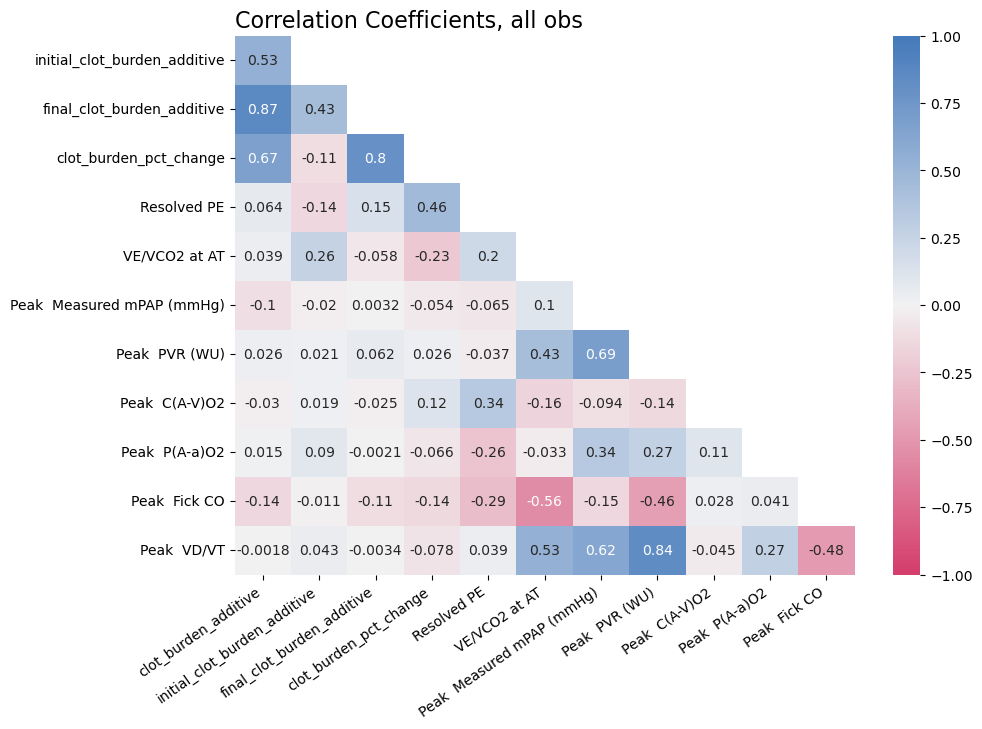

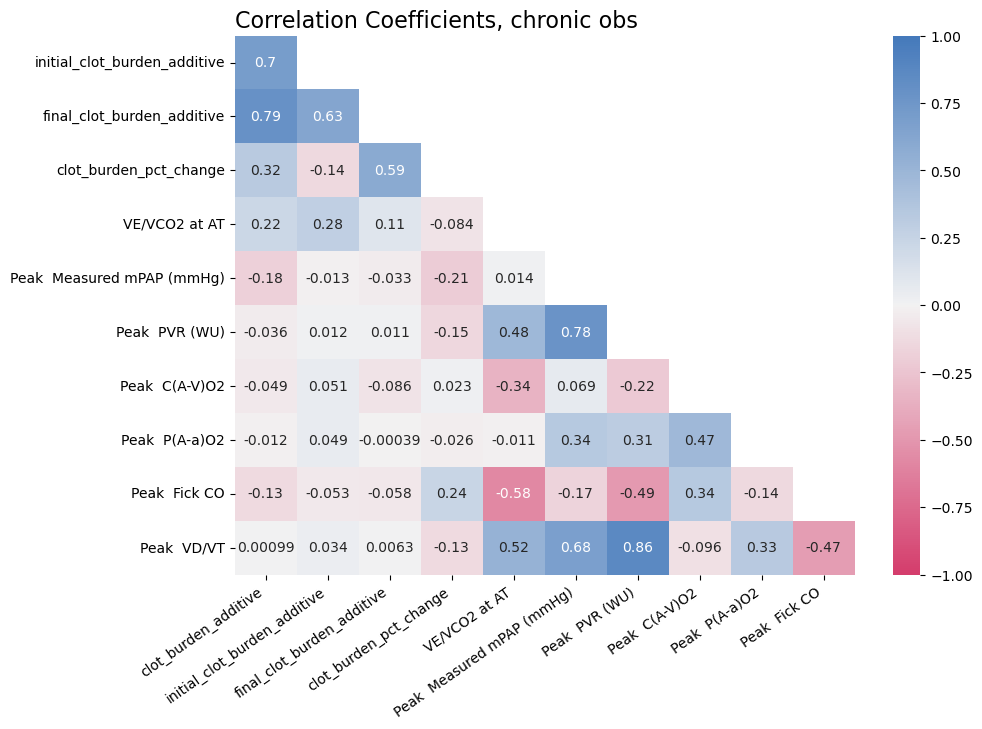

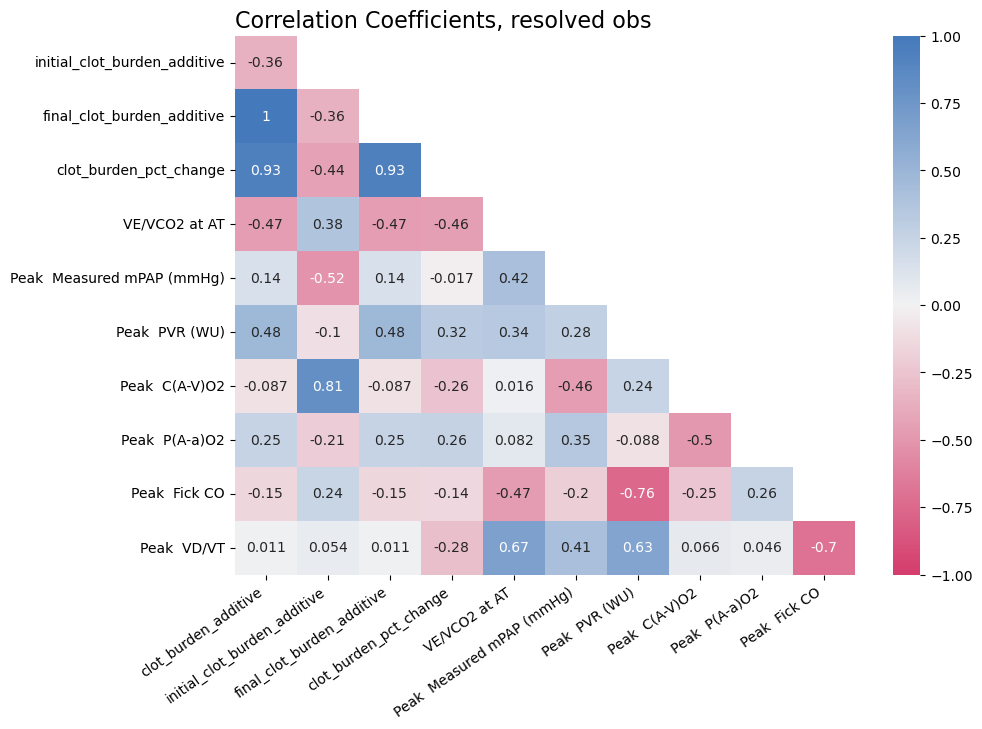

In [385]:
heatmap_colors = sns.diverging_palette(h_neg=359, h_pos=250, as_cmap=True)

# All 
mask = np.zeros_like(p)
mask[np.triu_indices_from(mask, 1)] = True
fig = plt.figure(figsize=(10, 7))
sns.heatmap(p, cmap=heatmap_colors, vmin=-1.0, vmax=1.0, center=0.0, annot=True, mask=mask)
plt.title("Correlation Coefficients, all obs", loc='left', fontsize=16)
plt.xticks(rotation=35, ha='right')
plt.savefig('output/plots/clot_hemo_corr_all.png', bbox_inches='tight')
plt.show()

# Chronic
mask = np.zeros_like(p_chronic)
mask[np.triu_indices_from(mask, 1)] = True
fig = plt.figure(figsize=(10, 7))
sns.heatmap(p_chronic, cmap=heatmap_colors, vmin=-1.0, vmax=1.0, center=0.0, annot=True, mask=mask)
plt.title("Correlation Coefficients, chronic obs", loc='left', fontsize=16)
plt.xticks(rotation=35, ha='right')
plt.savefig('output/plots/clot_hemo_corr_chronic.png', bbox_inches='tight')
plt.show()

# Chronic
mask = np.zeros_like(p_resolved)
mask[np.triu_indices_from(mask, 1)] = True
fig = plt.figure(figsize=(10, 7))
sns.heatmap(p_resolved, cmap=heatmap_colors, vmin=-1.0, vmax=1.0, center=0.0, annot=True, mask=mask)
plt.title("Correlation Coefficients, resolved obs", loc='left', fontsize=16)
plt.xticks(rotation=35, ha='right')
plt.savefig('output/plots/clot_hemo_corr_resolved.png', bbox_inches='tight')
plt.show()

# plt.annotate(f"n obs={len(df_sub_long.index.unique())}", xy=(0.7, 0.7), xycoords='axes fraction')

### Initial clot burden

### Change in clot burden

## association between PE clot volumes and the artery/vein volumes

# Old / Scratch

In [386]:
ols_models = []

indVars = {
    'VFAT': [measure+"_visceral_fat" for measure in measures],
    'SFAT': [measure+"_subcutaneous_fat" for measure in measures],
    'IFAT': [measure+"_intermuscular_fat" for measure in measures],
    'Muscle': [measure+"_muscle" for measure in measures],
    'Bone': [measure+"_bone" for measure in measures],
    'Composite 1': ['density_visceral_fat', 'density_subcutaneous_fat', 'density_intermuscular_fat', 'volume_muscle', 'density_muscle', 'mass_muscle', 'density_bone']
}

model_names = list(indVars.keys())

coef_df = pd.DataFrame()

for model in model_names:
    temp_model = regression_one_model(df=df, 
                                      Xindvars=indVars[model], 
                                      Yvar='clot_burden_additive', summary=False)
    ols_models.append(temp_model)
    results = temp_model.summary2().tables[1]
    results['Model'] = model
    coef_df = pd.concat([coef_df, results], axis=0)
    del temp_model
    del results
    
all_ols_models = Stargazer(ols_models)
all_ols_models.custom_columns(model_names, [1]*len(model_names))
all_ols_models.covariate_order(body_vars)

with open('output/Regs on clot burden.html', 'w') as f:
    f.write(all_ols_models.render_html())

NameError: name 'measures' is not defined

In [ ]:
g = sns.lmplot(
    data=df_sub_long,
    x='clot_burden_additive',
    y='value',
    hue='Resolved',
    col='variable',
    col_wrap=3,
    height=2.5,
    aspect=1.5,
    facet_kws={'sharey': False},
)

# plt.savefig('output/plots/lm_clot_burden_v_relationships')